# 利用thchs30为例建立一个语音识别系统

- 数据处理
- 搭建模型
    - cnn
    - rnn

## 1. 数据处理

input为输入音频数据，需要转化为频谱图数据，然后通过cnn处理图片的能力进行识别。

**1. 读取音频文件**

In [1]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

filepath = 'test.wav'

fs, wavsignal = wav.read(filepath)
plt.plot(wavsignal)
plt.show()

<Figure size 640x480 with 1 Axes>

**2. 构造汉明窗**

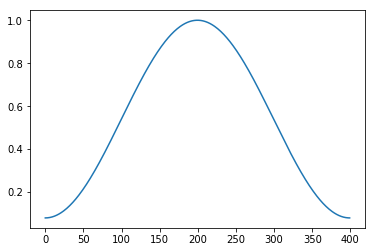

In [2]:
import numpy as np

x=np.linspace(0, 400 - 1, 400, dtype = np.int64)
w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1))
plt.plot(w)
plt.show()

**3. 对数据分帧**

- 帧长： 25ms
- 帧移： 10ms


```
采样点（s） = fs
采样点（ms）= fs / 1000
采样点（帧）= fs / 1000 * 帧长
```

In [3]:
time_window = 25
window_length = fs // 1000 * time_window

**4. 分帧加窗**

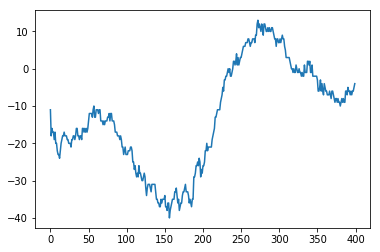

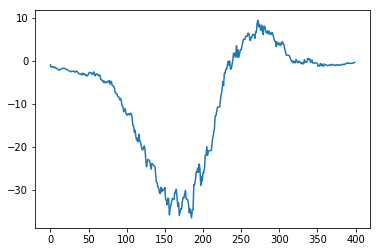

In [4]:
# 分帧
p_begin = 0
p_end = p_begin + window_length
frame = wavsignal[p_begin:p_end]
plt.plot(frame)
plt.show()
# 加窗
frame = frame * w
plt.plot(frame)
plt.show()

** 5. 傅里叶变换**

所谓时频图就是将时域信息转换到频域上去，具体原理可百度。人耳感知声音是通过

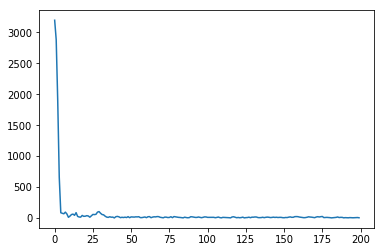

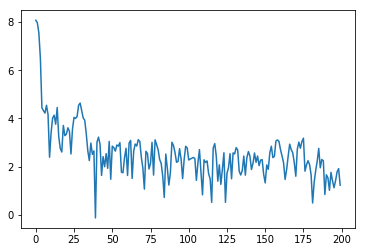

In [5]:
from scipy.fftpack import fft

# 进行快速傅里叶变换
frame_fft = np.abs(fft(frame))[:200]
plt.plot(frame_fft)
plt.show()

# 取对数，求db
frame_log = np.log(frame_fft)
plt.plot(frame_log)
plt.show()


- 分帧
- 加窗
- 傅里叶变换

In [6]:
import numpy as np
import scipy.io.wavfile as wav
from scipy.fftpack import fft


# 获取信号的时频图
def compute_fbank(file):
	x=np.linspace(0, 400 - 1, 400, dtype = np.int64)
	w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1) ) # 汉明窗
	fs, wavsignal = wav.read(file)
	# wav波形 加时间窗以及时移10ms
	time_window = 25 # 单位ms
	window_length = fs / 1000 * time_window # 计算窗长度的公式，目前全部为400固定值
	wav_arr = np.array(wavsignal)
	wav_length = len(wavsignal)
	#print(wav_arr.shape)
	#wav_length = wav_arr.shape[1]
	range0_end = int(len(wavsignal)/fs*1000 - time_window) // 10 # 计算循环终止的位置，也就是最终生成的窗数
	data_input = np.zeros((range0_end, 200), dtype = np.float) # 用于存放最终的频率特征数据
	data_line = np.zeros((1, 400), dtype = np.float)
	for i in range(0, range0_end):
		p_start = i * 160
		p_end = p_start + 400
		data_line = wav_arr[p_start:p_end]	
		data_line = data_line * w # 加窗
		data_line = np.abs(fft(data_line)) / wav_length
		data_input[i]=data_line[0:200] # 设置为400除以2的值（即200）是取一半数据，因为是对称的
	#print(data_input.shape)
	data_input = np.log(data_input + 1)
	data_input = data_input[::]
	data_input = np.transpose(data_input)  
	#data_input = pad_sequences(data_input, maxlen=800, dtype='float', padding='post', truncating='post').T	
	return data_input


- 该函数提取音频文件的时频图

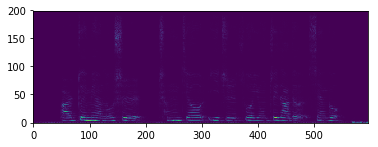

In [14]:
import matplotlib.pyplot as plt
filepath = 'test.wav'

a = compute_fbank(filepath)
plt.imshow(a, origin = 'lower')
plt.show()

## 2. 模型搭建

训练输入为时频图，标签为对应的拼音标签，如下所示：


搭建语音识别模型，采用了 CNN+CTC 的结构。
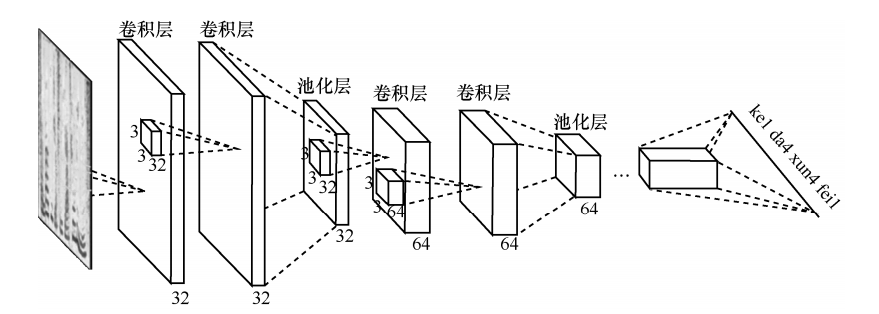

In [18]:
import keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D


def conv2d(size):
    return Conv2D(size, (3,3), use_bias=True, activation='relu',
        padding='same', kernel_initializer='he_normal')

def norm():
    return BatchNormalization(mode=0,axis=-1)

def maxpool():
    return MaxPooling2D(pool_size=(2,2), strides=None, padding="valid")


# x.shape=(none, none, none)
# output.shape = (1/2, 1/2, 1/2)
def cnn_cell(size, x, pool=True):
    x = norm(conv2d(size)(x))
    x = norm(conv2d(size)(x))
    if pool:
        x = maxpool(x)
    return x




class Amodel():
    """docstring for Amodel."""
    def __init__(self, arg):
        super(Amodel, self).__init__()
        self.arg = arg
        self._model_init()

    def _model_init(self):
        self.inputs = Input(name='inputs', shape=(None, 200, 1))
        self.h1 = cnn_cell(32, self.inputs)
        self.h2 = cnn_cell(64, self.h1)
        self.h3 = cnn_cell(128, self.h2)
        self.h4 = cnn_cell(128, self.h3, pool=False)
        self.h5 = cnn_cell(128, self.h4, pool=False)
